### Libraries

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.ensemble import BalancedBaggingClassifier
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone


### Load Test set

In [1]:
import pandas as pd

tst_path = "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/test.csv"
# ds_path = "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e8/playground-series-s4e8/imputed_train.csv"
df_tst = pd.read_csv(tst_path)
print(df_tst.shape)

(39098, 12)


In [2]:
missing_values_prop = df_tst.isnull().mean()
a = missing_values_prop*100.0
print("missings proportion:\n", a)

missings proportion:
 id                            0.0
person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


In [3]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


### Load Training set

In [4]:
ds_path = "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/train.csv"
# ds_path = "D:/Freelancer Projects/Kaggle Comp/playground-series-s4e8/playground-series-s4e8/imputed_train.csv"
df = pd.read_csv(ds_path)
print(df.shape)

(58645, 13)


In [5]:
# list the data types for each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [6]:
missing_values_prop = df.isnull().mean()
a = missing_values_prop*100.0
print("missings proportion:\n", a)

missings proportion:
 id                            0.0
person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


## Inspect Features

### handle Outliers (no need for CatBoost and etc...)

In [8]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")
        
calculate_outliers_percentage(df)



Percentage of outliers in id: 0.00%
Percentage of outliers in person_age: 4.17%
Percentage of outliers in person_income: 4.11%
Percentage of outliers in person_emp_length: 2.17%
Percentage of outliers in loan_amnt: 3.49%
Percentage of outliers in loan_int_rate: 0.06%
Percentage of outliers in loan_percent_income: 2.06%
Percentage of outliers in cb_person_cred_hist_length: 3.40%
Percentage of outliers in loan_status: 14.24%


In [9]:
def handle_outliers(df):
    """
    Handles outliers in a DataFrame by capping based on the IQR method.

    Parameters:
    - df (pd.DataFrame): DataFrame to process.

    Returns:
    - pd.DataFrame: DataFrame with outliers handled.
    """
    for column in df.select_dtypes(include=['number']).columns:
        if (column not in ['id', 'loan_status']):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Capping
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Apply to both training and test datasets
# df = handle_outliers(df)
# df_tst = handle_outliers(df_tst)

### person_age

#### train

In [10]:
# Get the frequencies
frequencies = df['person_age'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df['person_age'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  53
23: 13 %
22: 12 %
24: 11 %
25: 9 %
27: 8 %
26: 7 %
28: 6 %
29: 6 %
30: 4 %
31: 3 %
21: 3 %
32: 3 %
33: 2 %
36: 2 %
34: 2 %
37: 2 %
35: 1 %
38: 1 %
39: 1 %
40: 1 %
41: 1 %
43: 1 %
42: 0 %
44: 0 %
46: 0 %
45: 0 %
47: 0 %
48: 0 %
53: 0 %
51: 0 %
50: 0 %
52: 0 %
54: 0 %
49: 0 %
58: 0 %
55: 0 %
56: 0 %
60: 0 %
57: 0 %
65: 0 %
61: 0 %
20: 0 %
66: 0 %
64: 0 %
70: 0 %
62: 0 %
69: 0 %
59: 0 %
73: 0 %
84: 0 %
80: 0 %
76: 0 %
123: 0 %


#### test

In [11]:
# Get the frequencies
frequencies = df_tst['person_age'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df_tst['person_age'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  52
23: 13 %
22: 12 %
24: 11 %
25: 9 %
27: 8 %
26: 7 %
28: 6 %
29: 6 %
30: 4 %
31: 3 %
21: 3 %
32: 3 %
33: 2 %
36: 2 %
34: 2 %
37: 2 %
35: 1 %
38: 1 %
39: 1 %
41: 1 %
40: 1 %
43: 1 %
42: 0 %
44: 0 %
45: 0 %
47: 0 %
46: 0 %
48: 0 %
51: 0 %
49: 0 %
52: 0 %
53: 0 %
54: 0 %
55: 0 %
50: 0 %
58: 0 %
57: 0 %
56: 0 %
60: 0 %
70: 0 %
61: 0 %
66: 0 %
65: 0 %
62: 0 %
59: 0 %
69: 0 %
64: 0 %
20: 0 %
84: 0 %
63: 0 %
68: 0 %
94: 0 %


#### Delete values not presented in TEST set

In [12]:
'''
valid_obejcts = np.unique(df_tst['person_age'])

df['person_age'] = df['person_age'].apply(lambda x: None if x not in valid_obejcts else x)

# Assuming df is your DataFrame and 'column_name' is the specific column you're checking for None/NaN
df = df.dropna(subset=['person_age'])
'''

"\nvalid_obejcts = np.unique(df_tst['person_age'])\n\ndf['person_age'] = df['person_age'].apply(lambda x: None if x not in valid_obejcts else x)\n\n# Assuming df is your DataFrame and 'column_name' is the specific column you're checking for None/NaN\ndf = df.dropna(subset=['person_age'])\n"

In [13]:
if (np.unique(df_tst['person_age']).all() == np.unique(df['person_age']).all()):
    print("ok!") 
else: print("not ok!")
print(df.shape)

ok!
(58645, 13)


In [14]:
df['person_age'] = df['person_age'].clip(lower=0, upper=60)
df_tst['person_age'] = df_tst['person_age'].clip(lower=0, upper=60)

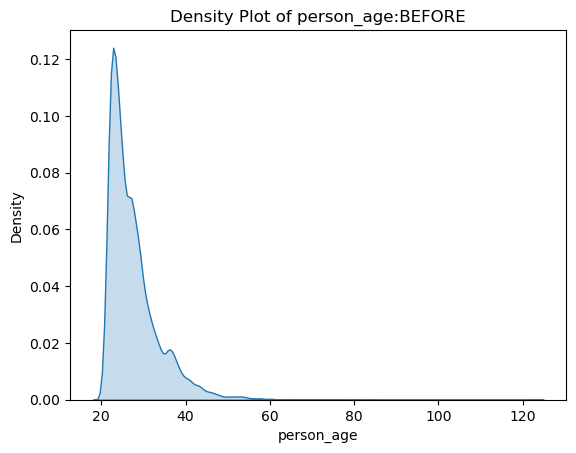

In [8]:
# Plot a density plot
sns.kdeplot(df['person_age'], fill=True)

# Add labels and title
plt.xlabel('person_age')
plt.ylabel('Density')
plt.title('Density Plot of person_age:BEFORE')
plt.show()

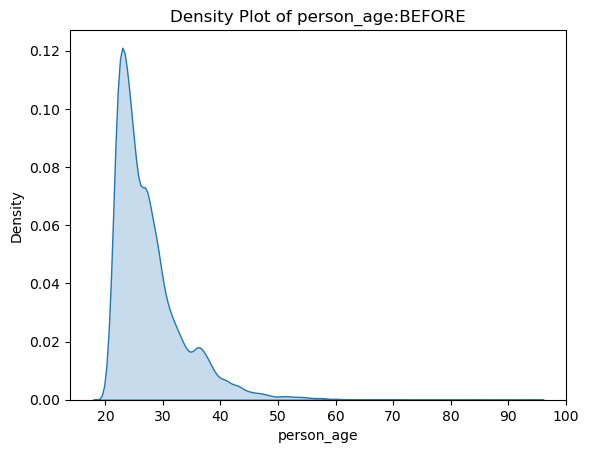

In [9]:
# Plot a density plot
sns.kdeplot(df_tst['person_age'], fill=True)

# Add labels and title
plt.xlabel('person_age')
plt.ylabel('Density')
plt.title('Density Plot of person_age:BEFORE')
plt.show()

<Axes: xlabel='person_age', ylabel='loan_status'>

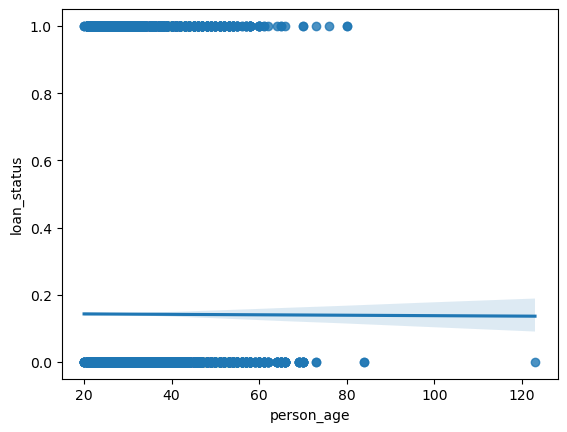

In [10]:
sns.regplot(x="person_age", y="loan_status", data=df)

### person_income

#### train

In [18]:
# Get the frequencies
frequencies = df['person_income'].value_counts()

print("Uniques: ", len(np.unique(df['person_income'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count}")

Uniques:  2641
60000: 4164
50000: 2992
30000: 2200
40000: 1981
70000: 1876
75000: 1681
45000: 1604
65000: 1484
80000: 1472
90000: 1353
48000: 1292
55000: 1209
42000: 1134
120000: 1089
36000: 1088
100000: 1060
54000: 999
35000: 923
85000: 881
72000: 824
24000: 742
52000: 599
110000: 574
44000: 508
95000: 498
38000: 458
78000: 433
25000: 432
150000: 426
34000: 399
32000: 387
33000: 375
62000: 369
130000: 332
39000: 328
58000: 304
56000: 300
140000: 282
37000: 279
43000: 277
28800: 273
49000: 270
38400: 262
96000: 259
84000: 256
68000: 256
66000: 255
125000: 225
57000: 225
63000: 220
47000: 220
105000: 212
46000: 209
53000: 208
69000: 198
64000: 197
59000: 197
31200: 193
115000: 188
29000: 183
28000: 181
51000: 150
102000: 143
27000: 140
39996: 137
20000: 137
74000: 131
54996: 129
200000: 127
41000: 125
108000: 123
67000: 121
69996: 121
26400: 118
33600: 118
73000: 110
88000: 109
43200: 109
65004: 106
62400: 104
98000: 102
51996: 102
26000: 102
87000: 101
18000: 95
180000: 93
31000: 92
52

#### Test

In [19]:
# Get the frequencies
frequencies = df_tst['person_income'].value_counts()

print("Uniques: ", len(np.unique(df_tst['person_income'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count}")

Uniques:  2196
60000: 2871
50000: 1974
30000: 1414
40000: 1347
70000: 1175
75000: 1098
45000: 1075
80000: 1053
65000: 973
90000: 913
48000: 904
55000: 854
42000: 818
36000: 759
120000: 709
100000: 703
54000: 624
85000: 599
35000: 596
72000: 567
24000: 466
110000: 425
52000: 406
95000: 337
44000: 333
38000: 293
78000: 286
25000: 281
150000: 265
32000: 264
34000: 254
62000: 244
39000: 243
33000: 223
84000: 213
130000: 213
58000: 211
68000: 208
38400: 200
140000: 179
43000: 175
96000: 173
56000: 170
49000: 169
125000: 162
63000: 160
37000: 160
105000: 152
57000: 151
47000: 150
59000: 148
28800: 146
46000: 143
64000: 140
66000: 137
31200: 133
115000: 133
53000: 128
28000: 127
29000: 124
69000: 115
51000: 92
200000: 90
74000: 85
108000: 82
54996: 82
102000: 81
73000: 81
62400: 81
67000: 80
20000: 80
27000: 79
31000: 76
43200: 73
51996: 72
45600: 71
33600: 71
26000: 71
18000: 69
39996: 68
65004: 65
62500: 63
69996: 63
83000: 60
135000: 59
52800: 59
25200: 58
41000: 57
26400: 57
92000: 56
880

#### Delete values not presented in TEST set

In [20]:
'''
valid_obejcts = np.unique(df_tst['person_income'])

df['person_income'] = df['person_income'].apply(lambda x: None if x not in valid_obejcts else x)

# Assuming df is your DataFrame and 'column_name' is the specific column you're checking for None/NaN
df = df.dropna(subset=['person_income'])
'''

"\nvalid_obejcts = np.unique(df_tst['person_income'])\n\ndf['person_income'] = df['person_income'].apply(lambda x: None if x not in valid_obejcts else x)\n\n# Assuming df is your DataFrame and 'column_name' is the specific column you're checking for None/NaN\ndf = df.dropna(subset=['person_income'])\n"

In [21]:
if (np.unique(df_tst['person_income']).all() == np.unique(df['person_income']).all()):
    print("ok!") 
else: print("not ok!")
print(df.shape)

ok!
(58645, 13)


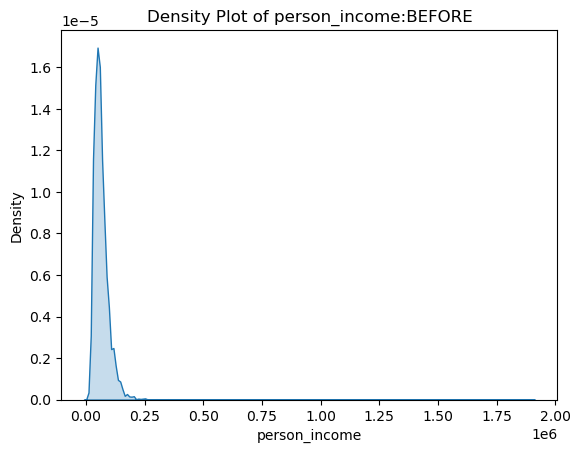

In [11]:
# Plot a density plot
sns.kdeplot(df['person_income'], fill=True)

# Add labels and title
plt.xlabel('person_income')
plt.ylabel('Density')
plt.title('Density Plot of person_income:BEFORE')
plt.show()

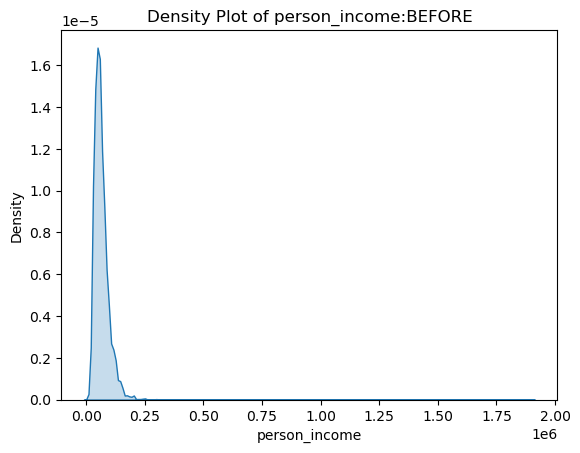

In [23]:
# Plot a density plot
sns.kdeplot(df_tst['person_income'], fill=True)

# Add labels and title
plt.xlabel('person_income')
plt.ylabel('Density')
plt.title('Density Plot of person_income:BEFORE')
plt.show()

<Axes: xlabel='person_income', ylabel='loan_status'>

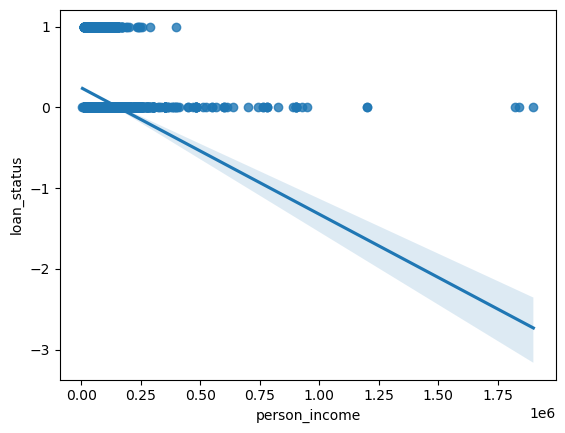

In [12]:
sns.regplot(x="person_income", y="loan_status", data=df)

### person_home_ownership

In [25]:
# Get the frequencies
frequencies = df['person_home_ownership'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df['person_home_ownership'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  4
RENT: 52 %
MORTGAGE: 42 %
OWN: 5 %
OTHER: 0 %


In [26]:
# Get the frequencies
frequencies = df_tst['person_home_ownership'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df_tst['person_home_ownership'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  4
RENT: 52 %
MORTGAGE: 43 %
OWN: 5 %
OTHER: 0 %


In [27]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['person_home_ownership'], df['loan_status'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# If p-value < 0.05, there is a significant relationship
if p_value < 0.05:
    print(f'The feature significantly affects the target class')
else:
    print(f'The feature does not significantly affect the target class')


The feature significantly affects the target class


<Axes: xlabel='person_home_ownership', ylabel='loan_status'>

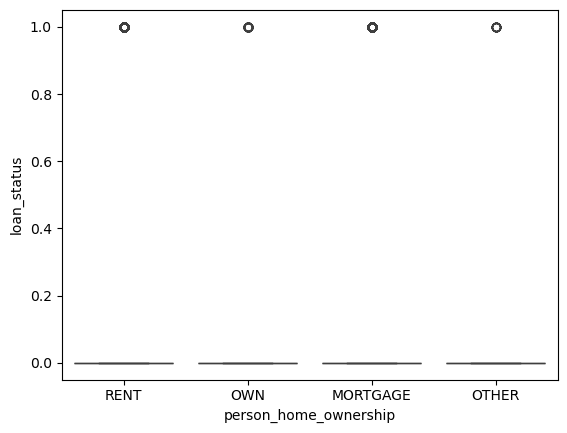

In [13]:
sns.boxplot(x="person_home_ownership", y="loan_status", data=df)

In [37]:
# Step 1: Explore the relationship (for understanding)
print(df.groupby(['person_home_ownership', 'loan_status'])['person_home_ownership'].value_counts())

person_home_ownership  loan_status
MORTGAGE               0              23341
                       1               1483
OTHER                  0                 74
                       1                 15
OWN                    0               3095
                       1                 43
RENT                   0              23785
                       1               6809
Name: count, dtype: int64


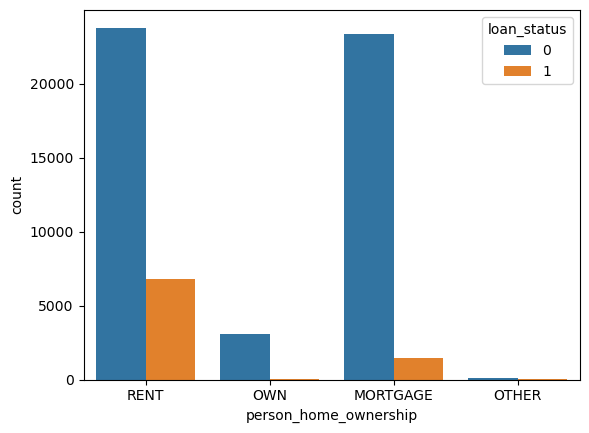

In [42]:
sns.countplot(data=df, x='person_home_ownership', hue='loan_status')
plt.show()

### person_emp_length

In [28]:
df['person_emp_length'].describe()

count    58645.000000
mean         4.701015
std          3.959784
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

In [29]:
df['person_emp_length'] = df['person_emp_length'].clip(lower=0, upper=23)

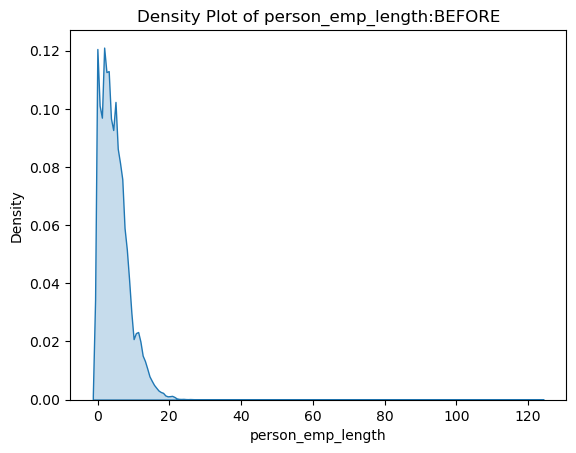

In [14]:
# Plot a density plot
sns.kdeplot(df['person_emp_length'], fill=True)

# Add labels and title
plt.xlabel('person_emp_length')
plt.ylabel('Density')
plt.title('Density Plot of person_emp_length:BEFORE')
plt.show()

In [31]:
df_tst['person_emp_length'] = df_tst['person_emp_length'].clip(lower=0, upper=23)

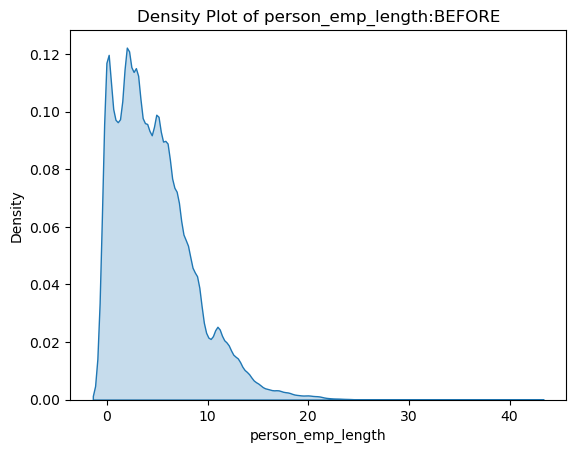

In [38]:
# Plot a density plot
sns.kdeplot(df_tst['person_emp_length'], fill=True)

# Add labels and title
plt.xlabel('person_emp_length')
plt.ylabel('Density')
plt.title('Density Plot of person_emp_length:BEFORE')
plt.show()

In [15]:
pearson_coef, p_value = stats.pearsonr(df['person_emp_length'], df['loan_status'])
print("The Pearson Correlation Coefficient: ", pearson_coef)
print("P =", p_value)  
print("P =", format(p_value, '.20f'))

The Pearson Correlation Coefficient:  -0.10042827021555924
P = 2.6819540145254447e-131
P = 0.00000000000000000000


<Axes: xlabel='person_emp_length', ylabel='loan_status'>

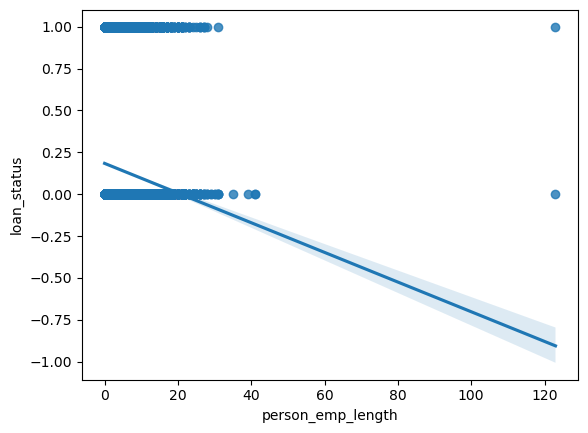

In [16]:
sns.regplot(x="person_emp_length", y="loan_status", data=df)

### loan_intent

In [35]:
# Get the frequencies
frequencies = df['loan_intent'].value_counts(normalize=True)

#print("Uniques: ", len(np.unique(df['fuel_type'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

EDUCATION: 20.92 %
MEDICAL: 18.64 %
PERSONAL: 17.08 %
VENTURE: 17.07 %
DEBTCONSOLIDATION: 15.57 %
HOMEIMPROVEMENT: 10.71 %


In [36]:
# Get the frequencies
frequencies = df_tst['loan_intent'].value_counts(normalize=True)

#print("Uniques: ", len(np.unique(df_tst['fuel_type'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

EDUCATION: 20.66 %
MEDICAL: 19.05 %
PERSONAL: 17.43 %
VENTURE: 16.96 %
DEBTCONSOLIDATION: 15.13 %
HOMEIMPROVEMENT: 10.78 %


<Axes: xlabel='loan_intent', ylabel='loan_status'>

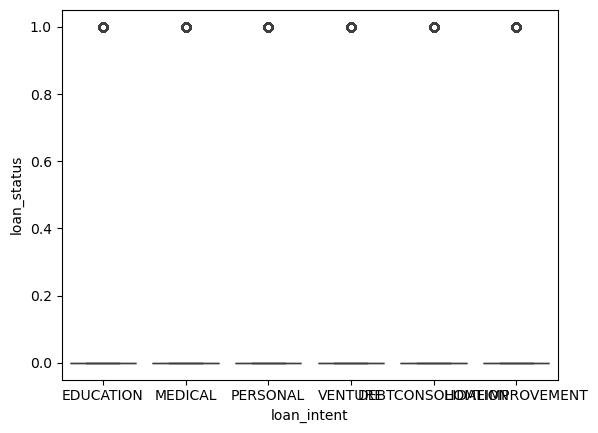

In [17]:
sns.boxplot(x="loan_intent", y="loan_status", data=df)

In [38]:
# Create a contingency table
contingency_table = pd.crosstab(df['loan_intent'], df['loan_status'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# If p-value < 0.05, there is a significant relationship
if p_value < 0.05:
    print(f'The feature significantly affects the target class')
else:
    print(f'The feature does not significantly affect the target class')

The feature significantly affects the target class


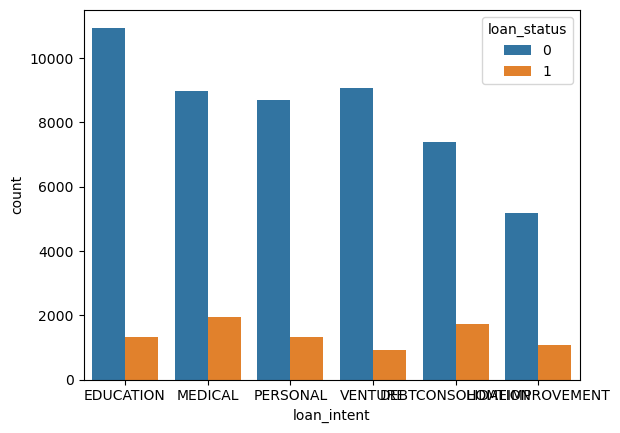

In [43]:
sns.countplot(data=df, x='loan_intent', hue='loan_status')
plt.show()

### loan_grade

In [39]:
# Get the frequencies
frequencies = df['loan_grade'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df['loan_grade'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

Uniques:  7
A: 35.78 %
B: 34.79 %
C: 18.82 %
D: 8.58 %
E: 1.72 %
F: 0.25 %
G: 0.06 %


In [40]:
# Get the frequencies
frequencies = df_tst['loan_grade'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df_tst['loan_grade'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

Uniques:  7
A: 35.82 %
B: 34.79 %
C: 19.08 %
D: 8.36 %
E: 1.63 %
F: 0.27 %
G: 0.05 %


<Axes: xlabel='loan_grade', ylabel='loan_status'>

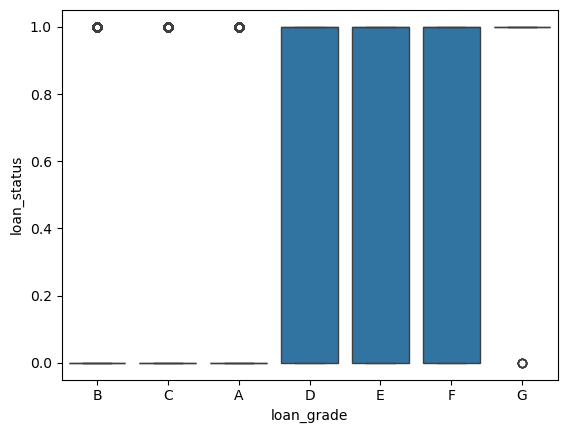

In [41]:
sns.boxplot(x="loan_grade", y="loan_status", data=df)

In [42]:
# Create a contingency table
contingency_table = pd.crosstab(df['loan_grade'], df['loan_status'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# If p-value < 0.05, there is a significant relationship
if p_value < 0.05:
    print(f'The feature significantly affects the target class')
else:
    print(f'The feature does not significantly affect the target class')

The feature significantly affects the target class


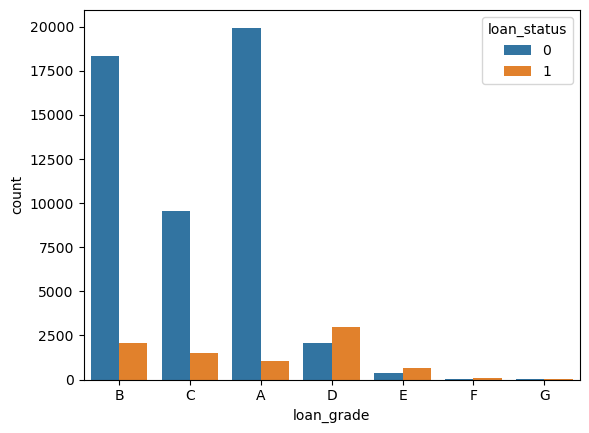

In [44]:
sns.countplot(data=df, x='loan_grade', hue='loan_status')
plt.show()

### loan_amnt

In [43]:
df['loan_amnt'].describe()

count    58645.000000
mean      9217.556518
std       5563.807384
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

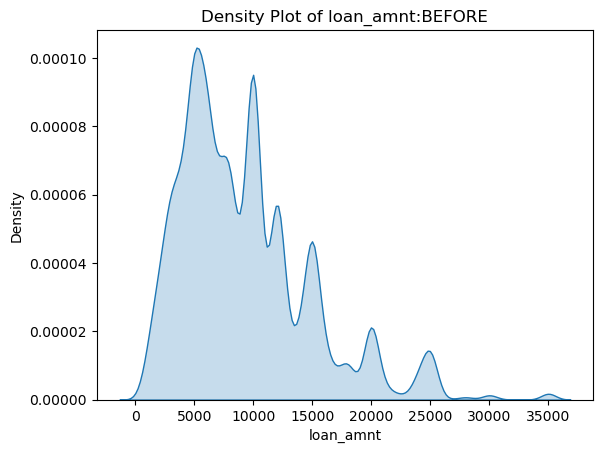

In [18]:
# Plot a density plot
sns.kdeplot(df['loan_amnt'], fill=True)

# Add labels and title
plt.xlabel('loan_amnt')
plt.ylabel('Density')
plt.title('Density Plot of loan_amnt:BEFORE')
plt.show()

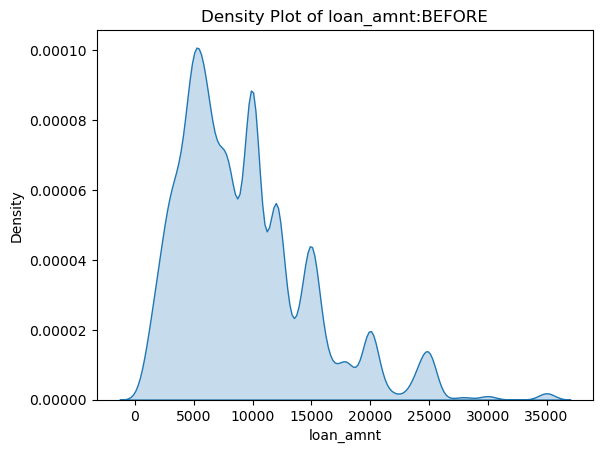

In [45]:
# Plot a density plot
sns.kdeplot(df_tst['loan_amnt'], fill=True)

# Add labels and title
plt.xlabel('loan_amnt')
plt.ylabel('Density')
plt.title('Density Plot of loan_amnt:BEFORE')
plt.show()

In [19]:
pearson_coef, p_value = stats.pearsonr(df['loan_amnt'], df['loan_status'])
print("The Pearson Correlation Coefficient: ", pearson_coef)
print("P =", p_value)  
print("P =", format(p_value, '.20f'))

The Pearson Correlation Coefficient:  0.1449823702652079
P = 6.7948563022928965e-273
P = 0.00000000000000000000


<Axes: xlabel='loan_amnt', ylabel='loan_status'>

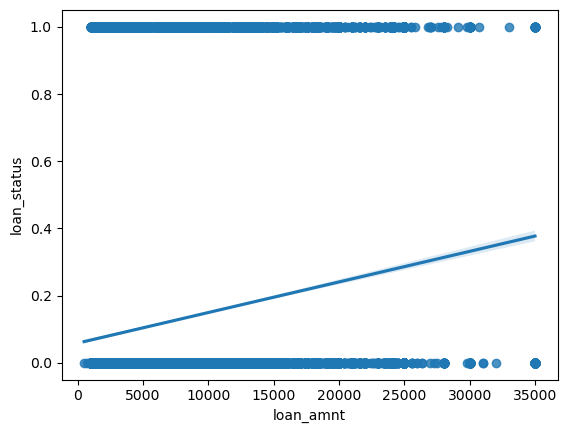

In [20]:
sns.regplot(x="loan_amnt", y="loan_status", data=df)

### loan_int_rate

In [48]:
df['loan_int_rate'].describe()

count    58645.000000
mean        10.677874
std          3.034697
min          5.420000
25%          7.880000
50%         10.750000
75%         12.990000
max         23.220000
Name: loan_int_rate, dtype: float64

In [49]:
df['loan_int_rate'] = df['loan_int_rate'].clip(lower=0, upper=20)
df_tst['loan_int_rate'] = df_tst['loan_int_rate'].clip(lower=0, upper=20)

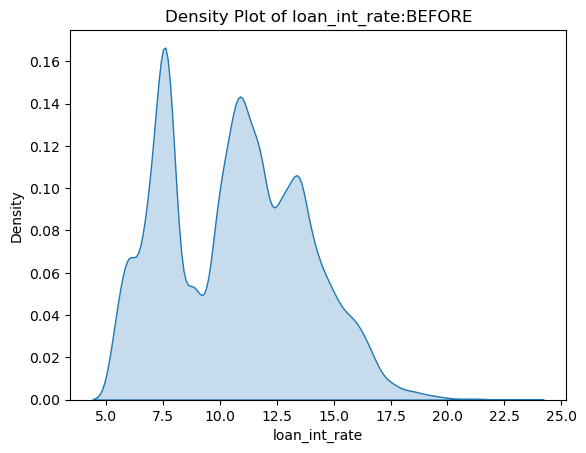

In [21]:
# Plot a density plot
sns.kdeplot(df['loan_int_rate'], fill=True)

# Add labels and title
plt.xlabel('loan_int_rate')
plt.ylabel('Density')
plt.title('Density Plot of loan_int_rate:BEFORE')
plt.show()

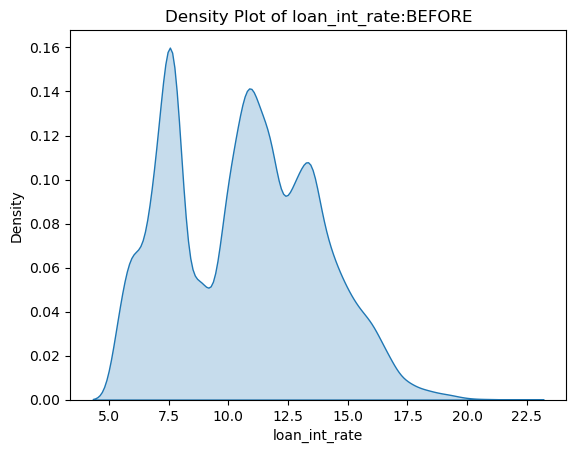

In [40]:
# Plot a density plot
sns.kdeplot(df_tst['loan_int_rate'], fill=True)

# Add labels and title
plt.xlabel('loan_int_rate')
plt.ylabel('Density')
plt.title('Density Plot of loan_int_rate:BEFORE')
plt.show()

In [24]:
pearson_coef, p_value = stats.pearsonr(df['loan_int_rate'], df['loan_status'])
print("The Pearson Correlation Coefficient: ", pearson_coef)
print("P =", p_value)  
print("P =", format(p_value, '.20f'))

The Pearson Correlation Coefficient:  0.33894767218478367
P = 0.0
P = 0.00000000000000000000


<Axes: xlabel='loan_int_rate', ylabel='loan_status'>

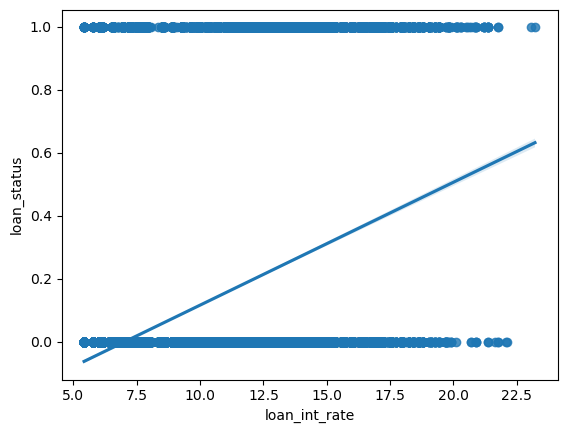

In [25]:
sns.regplot(x="loan_int_rate", y="loan_status", data=df)

### loan_percent_income

In [54]:
df['loan_percent_income'].describe()

count    58645.000000
mean         0.159238
std          0.091692
min          0.000000
25%          0.090000
50%          0.140000
75%          0.210000
max          0.830000
Name: loan_percent_income, dtype: float64

In [55]:
df['loan_percent_income'] = df['loan_percent_income'].clip(lower=0, upper=0.55)
df_tst['loan_percent_income'] = df_tst['loan_percent_income'].clip(lower=0, upper=0.55)

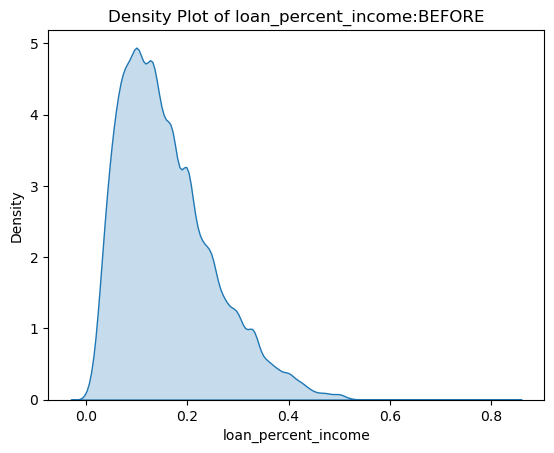

In [26]:
# Plot a density plot
sns.kdeplot(df['loan_percent_income'], fill=True)

# Add labels and title
plt.xlabel('loan_percent_income')
plt.ylabel('Density')
plt.title('Density Plot of loan_percent_income:BEFORE')
plt.show()

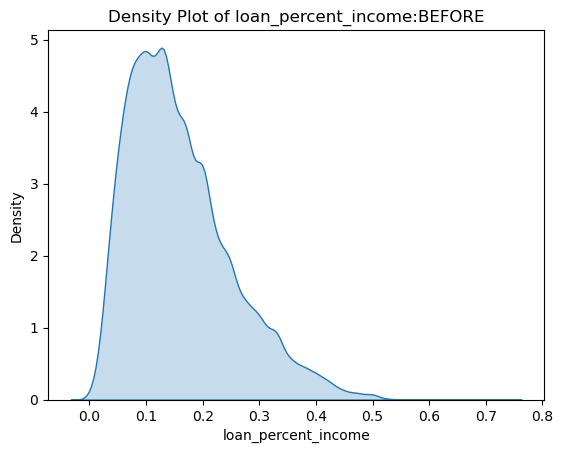

In [27]:
# Plot a density plot
sns.kdeplot(df_tst['loan_percent_income'], fill=True)

# Add labels and title
plt.xlabel('loan_percent_income')
plt.ylabel('Density')
plt.title('Density Plot of loan_percent_income:BEFORE')
plt.show()

In [28]:
pearson_coef, p_value = stats.pearsonr(df['loan_percent_income'], df['loan_status'])
print("The Pearson Correlation Coefficient: ", pearson_coef)
print("P =", p_value)  
print("P =", format(p_value, '.20f'))

The Pearson Correlation Coefficient:  0.37827969693604996
P = 0.0
P = 0.00000000000000000000


<Axes: xlabel='loan_percent_income', ylabel='loan_status'>

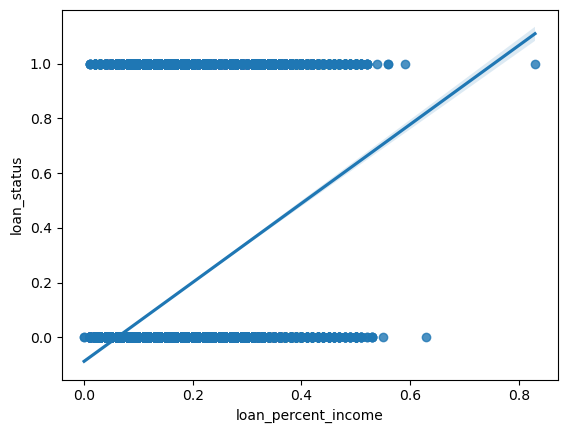

In [29]:
sns.regplot(x="loan_percent_income", y="loan_status", data=df)

### cb_person_default_on_file

In [60]:
# Get the frequencies
frequencies = df['cb_person_default_on_file'].value_counts(normalize=True)

#print("Uniques: ", len(np.unique(df['accident'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

N: 85.16 %
Y: 14.84 %


In [61]:
# Get the frequencies
frequencies = df_tst['cb_person_default_on_file'].value_counts(normalize=True)

#print("Uniques: ", len(np.unique(df_tst['accident'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.2f} %")

N: 84.98 %
Y: 15.02 %


<Axes: xlabel='cb_person_default_on_file', ylabel='loan_status'>

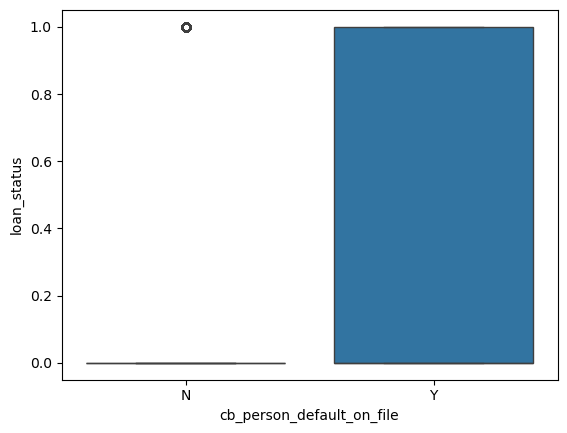

In [62]:
sns.boxplot(x="cb_person_default_on_file", y="loan_status", data=df)

In [63]:
# Create a contingency table
contingency_table = pd.crosstab(df['cb_person_default_on_file'], df['loan_status'])

# Perform the Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# If p-value < 0.05, there is a significant relationship
if p_value < 0.05:
    print(f'The feature significantly affects the target class')
else:
    print(f'The feature does not significantly affect the target class')

The feature significantly affects the target class


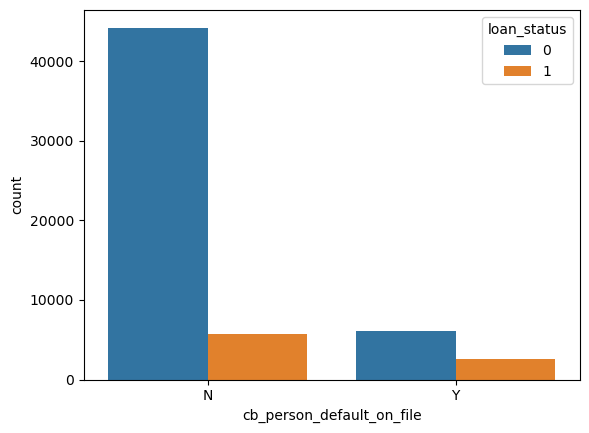

In [45]:
sns.countplot(data=df, x='cb_person_default_on_file', hue='loan_status')
plt.show()

### cb_person_cred_hist_length

In [64]:
df['cb_person_cred_hist_length'].describe()

count    58645.000000
mean         5.813556
std          4.029196
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64

In [65]:
df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].clip(lower=0, upper=20)
df_tst['cb_person_cred_hist_length'] = df_tst['cb_person_cred_hist_length'].clip(lower=0, upper=20)

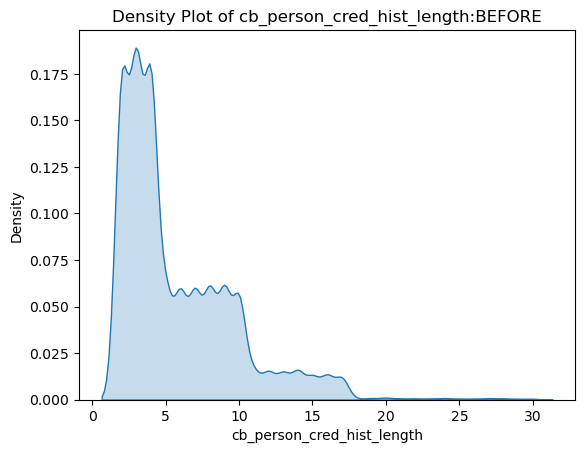

In [30]:
# Plot a density plot
sns.kdeplot(df['cb_person_cred_hist_length'], fill=True)

# Add labels and title
plt.xlabel('cb_person_cred_hist_length')
plt.ylabel('Density')
plt.title('Density Plot of cb_person_cred_hist_length:BEFORE')
plt.show()

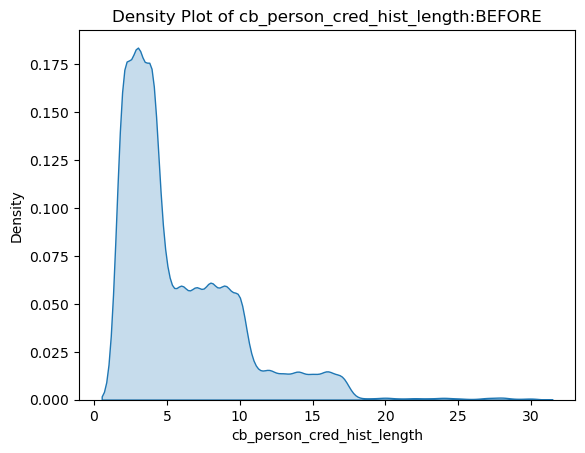

In [31]:
# Plot a density plot
sns.kdeplot(df_tst['cb_person_cred_hist_length'], fill=True)

# Add labels and title
plt.xlabel('cb_person_cred_hist_length')
plt.ylabel('Density')
plt.title('Density Plot of cb_person_cred_hist_length:BEFORE')
plt.show()

<Axes: xlabel='cb_person_cred_hist_length', ylabel='loan_status'>

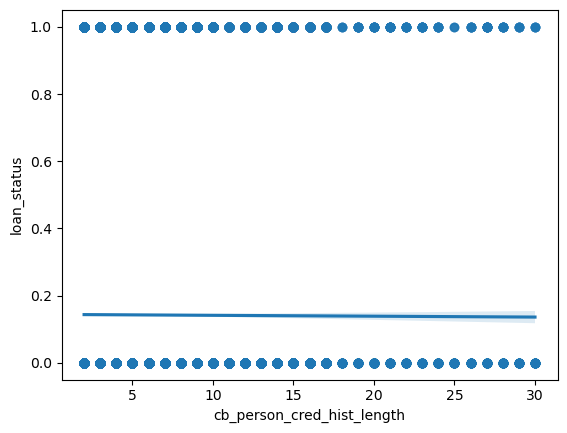

In [32]:
sns.regplot(x="cb_person_cred_hist_length", y="loan_status", data=df)

### loan_status

In [69]:
# Get the frequencies
frequencies = df['loan_status'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(df['loan_status'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  2
0: 86 %
1: 14 %


## Save Clear datasets

In [88]:
# Save DataFrame to a specific path as a CSV file
df.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e9/clean_train.csv", index=False)
df_tst.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e9/clean_test.csv", index=False)

## Train with Catboost

In [63]:
# Splitting the dataset into train and test
X = df.drop(['loan_status', 'id'], axis=1) 
y = df['loan_status']

# Categorical and continuous columns
categorical_cols = [col for i, col in enumerate(X.columns) if X[col].dtype == 'object'] # CatBoost will handle these as categorical
# categorical_cols = ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident']
print(categorical_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


### try oversampling?

In [127]:
# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Apply the same transformation to test set
    label_encoders[col] = le  # Store the label encoder in case you need it later


from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [128]:
print(X_train.shape)
print(X_resampled.shape)

(46916, 11)
(80416, 11)


### try under-sampling?

In [64]:
from imblearn.under_sampling import RandomUnderSampler

'''
# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  # Apply the same transformation to test set
    label_encoders[col] = le  # Store the label encoder in case you need it later

'''

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42, replacement=False)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [65]:
print(X_train.shape)
# Get the frequencies
frequencies = y_resampled.value_counts(normalize=True)

print("Uniques: ", len(np.unique(y_resampled)))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

(46916, 11)
Uniques:  2
0: 59 %
1: 41 %


### Ensemble with Undersamp?

In [158]:
from imblearn.under_sampling import RandomUnderSampler

# Define CatBoost model
catboost_model = CatBoostClassifier(
    # class_weights=[1, 4],    # if not Sampling
    iterations=1000,          # Start with 1000 iterations
    learning_rate=0.03,       # Moderate learning rate for stable training (defaul 0.03)
    depth=7,                  # Reasonable tree depth (6-10 typically works well)
    cat_features=categorical_cols,  # Categorical feature names or indices
    task_type="GPU",          # Enables GPU usage
    devices='0',              # Use GPU index 0 (or specify multiple GPUs if available)
    verbose=100               # Print output every 100 iterations
)

# Define the undersampler
undersampler = RandomUnderSampler(sampling_strategy='not majority', random_state=42)

# Define bagging classifier with undersampling
n_estimators = 10  # Define the number of models in the ensemble
predictions = []

for i in range(n_estimators):
    # Apply undersampling to create a balanced subset
    X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
    
    # Clone the model to ensure a fresh model for each iteration
    model = clone(catboost_model)
    
    # Fit the model on the undersampled data
    model.fit(X_resampled, y_resampled)
    
    # Predict on the test set and store predictions
    y_pred = model.predict(df_tst.drop(columns=['id']))
    predictions.append(y_pred)

# Majority vote across the ensemble
final_predictions = np.round(np.mean(predictions, axis=0))

# Create a DataFrame with 'id' and predicted 'class'
results_df = pd.DataFrame({
    'id': df_tst['id'],
    'loan_status': final_predictions
})

saved_file = 'Ensemble'
# Save the results to a CSV file
results_df.to_csv(f'D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/{saved_file}.csv', index=False)

0:	learn: 0.6545783	total: 78.4ms	remaining: 1m 18s
100:	learn: 0.1707682	total: 9.31s	remaining: 1m 22s
200:	learn: 0.1594789	total: 18.1s	remaining: 1m 11s
300:	learn: 0.1530680	total: 26.7s	remaining: 1m 2s
400:	learn: 0.1487979	total: 35.5s	remaining: 53s
500:	learn: 0.1454056	total: 44.3s	remaining: 44.1s
600:	learn: 0.1424056	total: 53.1s	remaining: 35.2s
700:	learn: 0.1397295	total: 1m 1s	remaining: 26.4s
800:	learn: 0.1382336	total: 1m 10s	remaining: 17.5s
900:	learn: 0.1365863	total: 1m 19s	remaining: 8.73s
999:	learn: 0.1352875	total: 1m 28s	remaining: 0us
0:	learn: 0.6545782	total: 73.9ms	remaining: 1m 13s
100:	learn: 0.1707682	total: 9.22s	remaining: 1m 22s
200:	learn: 0.1594789	total: 18s	remaining: 1m 11s
300:	learn: 0.1530680	total: 26.8s	remaining: 1m 2s
400:	learn: 0.1487980	total: 35.4s	remaining: 52.9s
500:	learn: 0.1454056	total: 44.1s	remaining: 43.9s
600:	learn: 0.1424056	total: 52.7s	remaining: 35s
700:	learn: 0.1397295	total: 1m 1s	remaining: 26.3s
800:	learn: 0

### Focal loss

In [116]:
# Initialize CatBoost with focal loss
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.02,
    depth=8,
    custom_metric=['Focal:focal_alpha=0.25;focal_gamma=2'],
    #task_type="GPU",
    cat_features=categorical_cols,
    devices='0',
    verbose=100
)

model.fit(X_train, y_train)


0:	learn: 0.6655715	total: 76.9ms	remaining: 3m 50s
100:	learn: 0.1778679	total: 5.8s	remaining: 2m 46s
200:	learn: 0.1627970	total: 11.4s	remaining: 2m 39s
300:	learn: 0.1564079	total: 16.8s	remaining: 2m 30s
400:	learn: 0.1521835	total: 22s	remaining: 2m 22s
500:	learn: 0.1479946	total: 27.5s	remaining: 2m 17s
600:	learn: 0.1439090	total: 33s	remaining: 2m 11s
700:	learn: 0.1398226	total: 38.8s	remaining: 2m 7s
800:	learn: 0.1360388	total: 44.7s	remaining: 2m 2s
900:	learn: 0.1325920	total: 50.6s	remaining: 1m 57s
1000:	learn: 0.1290057	total: 56.9s	remaining: 1m 53s
1100:	learn: 0.1259849	total: 1m 2s	remaining: 1m 48s
1200:	learn: 0.1231134	total: 1m 8s	remaining: 1m 43s
1300:	learn: 0.1204756	total: 1m 14s	remaining: 1m 37s
1400:	learn: 0.1181531	total: 1m 20s	remaining: 1m 32s
1500:	learn: 0.1159665	total: 1m 26s	remaining: 1m 26s
1600:	learn: 0.1136020	total: 1m 32s	remaining: 1m 21s
1700:	learn: 0.1116809	total: 1m 38s	remaining: 1m 15s
1800:	learn: 0.1094959	total: 1m 44s	rema

### Train

In [66]:
# Initialize CatBoost Regressor with GPU support
model = CatBoostClassifier(
    # class_weights=[1, 4],    # if not Sampling
    iterations=1000,          # Start with 1000 iterations
    learning_rate=0.03,       # Moderate learning rate for stable training (defaul 0.03)
    depth=7,                  # Reasonable tree depth (6-10 typically works well)
    cat_features=categorical_cols,  # Categorical feature names or indices
    task_type="GPU",          # Enables GPU usage
    devices='0',              # Use GPU index 0 (or specify multiple GPUs if available)
    verbose=100               # Print output every 100 iterations
)

model.fit(X_resampled, y_resampled)

0:	learn: 0.6650125	total: 90.2ms	remaining: 1m 30s
100:	learn: 0.2877123	total: 8.01s	remaining: 1m 11s
200:	learn: 0.2654041	total: 15.8s	remaining: 1m 2s
300:	learn: 0.2522299	total: 23.4s	remaining: 54.3s
400:	learn: 0.2401845	total: 30.8s	remaining: 46s
500:	learn: 0.2331145	total: 38.2s	remaining: 38s
600:	learn: 0.2280571	total: 45.6s	remaining: 30.3s
700:	learn: 0.2240563	total: 53.2s	remaining: 22.7s
800:	learn: 0.2210183	total: 1m	remaining: 15.1s
900:	learn: 0.2188814	total: 1m 8s	remaining: 7.53s
999:	learn: 0.2172576	total: 1m 15s	remaining: 0us


In [67]:
y_pred = model.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9356296359450934
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10087
           1       0.75      0.82      0.78      1642

    accuracy                           0.94     11729
   macro avg       0.86      0.89      0.87     11729
weighted avg       0.94      0.94      0.94     11729

[[9629  458]
 [ 297 1345]]


## Predict Test set

In [132]:
# Make predictions
predictions = model.predict(df_tst.drop(columns=['id']))

# Create a DataFrame with 'id' and predicted 'class'
results_df = pd.DataFrame({
    'id': df_tst['id'],
    'loan_status': predictions
})

saved_file = 'oversamp_over'
# Save the results to a CSV file
results_df.to_csv(f'D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/{saved_file}.csv', index=False)

In [133]:
my_df = pd.read_csv(f'D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/{saved_file}.csv')
# Get the frequencies
frequencies = my_df['loan_status'].value_counts(normalize=True)

print("Uniques: ", len(np.unique(my_df['loan_status'])))

# Print each category and its frequency line by line
for category, count in frequencies.items():
    print(f"{category}: {count * 100:.0f} %")

Uniques:  2
0: 92 %
1: 8 %


## Train with AutoGluon

In [8]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test
X = df.drop(['id'], axis=1) 
y = df['loan_status'] #asdaddsdw

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #2432534
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler() #asdasd
X_resampled, _ = undersampler.fit_resample(X_train, y_train) #asdadsa

# Save DataFrame to a specific path as a CSV file
X_resampled.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/X_train_resampled.csv", index=False)
X_test.to_csv("D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/X_test.csv", index=False)

ModuleNotFoundError: No module named 'imblearn'

In [14]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_url = 'D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/'
train_data = TabularDataset(f'{data_url}X_train.csv')
train_data.head()

Loaded data from: D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/X_train.csv | Columns = 12 / 12 | Rows = 46916 -> 46916


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,36,50000,RENT,0.0,HOMEIMPROVEMENT,C,7200,13.85,0.14,Y,15,0
1,27,43200,RENT,3.0,DEBTCONSOLIDATION,C,5000,11.66,0.12,Y,9,0
2,25,70000,MORTGAGE,0.0,EDUCATION,A,8000,7.88,0.11,N,3,0
3,39,75000,MORTGAGE,2.0,DEBTCONSOLIDATION,A,15000,6.54,0.20,N,11,0
4,22,45600,RENT,5.0,MEDICAL,A,4000,7.66,0.09,N,2,0


In [15]:
label = 'loan_status'

# Initialize and train the AutoGluon TabularPredictor
predictor = TabularPredictor(label=label, eval_metric = 'f1').fit(
    train_data=train_data,
    #presets='good_quality',  # Preset for higher accuracy, can adjust to 'medium_quality_faster_train' for faster training
    verbosity=2        # Verbosity level for detailed output
)

No path specified. Models will be saved in: "AutogluonModels\ag-20241030_190709"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.20
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       8.80 GB / 15.96 GB (55.2%)
Disk Space Avail:   38.91 GB / 344.91 GB (11.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial proto

In [16]:
test_data = TabularDataset(f'{data_url}X_test.csv')

y_pred = predictor.predict(test_data)
y_pred.head()

Loaded data from: D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/X_test.csv | Columns = 12 / 12 | Rows = 11729 -> 11729


0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [17]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
# Accuracy
print(f"Accuracy: {accuracy_score(test_data.loan_status, y_pred)}")

# Classification Report
print(classification_report(test_data.loan_status, y_pred))

# Confusion Matrix
print(confusion_matrix(test_data.loan_status, y_pred))

Accuracy: 0.9533634580953193
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.91      0.74      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.94      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729

[[9974  113]
 [ 434 1208]]


In [18]:
predictor.evaluate(test_data, silent=True)

{'f1': 0.8153898076274047,
 'accuracy': 0.9533634580953193,
 'balanced_accuracy': 0.8622428236099889,
 'mcc': 0.7951742763306155,
 'roc_auc': 0.9544864067509138,
 'precision': 0.9144587433762301,
 'recall': 0.7356881851400731}

In [13]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.915850,0.879285,accuracy,0.027924,0.026648,24.025107,0.027924,0.026648,24.025107,1,True,7
1,LightGBM,0.912610,0.889717,accuracy,0.048869,0.013960,0.812878,0.048869,0.013960,0.812878,1,True,4
2,XGBoost,0.912610,0.883010,accuracy,0.100732,0.111359,1.471454,0.100732,0.111359,1.471454,1,True,10
3,WeightedEnsemble_L2,0.912610,0.895678,accuracy,0.337535,0.226789,71.420580,0.005984,0.000998,0.163536,2,True,13
4,LightGBMLarge,0.908091,0.883756,accuracy,0.101727,0.008976,1.173872,0.101727,0.008976,1.173872,1,True,12
5,NeuralNetTorch,0.904595,0.858420,accuracy,0.088365,0.016955,27.660088,0.088365,0.016955,27.660088,1,True,11
6,RandomForestEntr,0.899139,0.849478,accuracy,0.283237,0.095223,2.161511,0.283237,0.095223,2.161511,1,True,6
7,RandomForestGini,0.895814,0.847988,accuracy,0.289260,0.112793,2.635412,0.289260,0.112793,2.635412,1,True,5
8,ExtraTreesEntr,0.889505,0.842027,accuracy,0.373056,0.078963,1.187731,0.373056,0.078963,1.187731,1,True,9
9,LightGBMXT,0.888823,0.853204,accuracy,0.016954,0.009973,3.236861,0.016954,0.009973,3.236861,1,True,3


In [19]:
# Make predictions
predictions = predictor.predict(df_tst.drop(columns=['id']))

# Create a DataFrame with 'id' and predicted 'class'
results_df = pd.DataFrame({
    'id': df_tst['id'],
    'loan_status': predictions
})

# Save the results to a CSV file
results_df.to_csv('D:/Freelancer Projects/Kaggle Comp/playground-series-s4e10/gloun_good.csv', index=False)